In [1]:
import oasis
con = oasis.getTempCredentials()

print()
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])




Requesting new temp credentials.
Temp database ready to use.

https://5904e8d8a65f.arangodb.cloud:8529
Username: TUT6dt4m3ow9x5gw8zezi1d4
Password: TUTonuuqg4twdy3s0koexhhk
Database: TUTqi1f7ig9i2ex2veh8opmsd


In [2]:
!./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --default-replication-factor 3  --input-directory "data/dgl_data_dump"

2020-05-18T06:39:37Z [27916] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://5904e8d8a65f.arangodb.cloud:8529'
2020-05-18T06:39:39Z [27916] INFO [abeb4] {restore} Database name in source dump is 'dgl_hetrograph_itsm_db'
2020-05-18T06:39:39Z [27916] INFO [9b414] {restore} # Re-creating document collection 'customer'...
2020-05-18T06:39:45Z [27916] INFO [9b414] {restore} # Re-creating document collection 'incident'...
2020-05-18T06:39:53Z [27916] INFO [9b414] {restore} # Re-creating document collection 'support_org'...
2020-05-18T06:40:00Z [27916] INFO [9b414] {restore} # Re-creating document collection 'vendor'...
2020-05-18T06:40:06Z [27916] INFO [9b414] {restore} # Re-creating edge collection 'incident_customer'...
2020-05-18T06:40:14Z [27916] INFO [9b414] {restore} # Re-creating edge collection 'incident_support_org'...
2020-05-18T06:40:21Z [27916] INFO [9b414] {restore} # Re-creating edge collection 'incident_vendor'...
2020-05-18T06:40:29Z [27916] INFO [6d69f] {restore} # 

In [3]:
vcols = {"incident":{"D_sys_mod_count", "D_sys_mod_count", "D_reopen_count", "urgency", "incident_state",\
                     "u_symptom", "impact", "contact_type","u_priority_confirmation", "cmdb_ci",\
                      "rfc", "problem_id", "caused_by", "location", "knowledge", "resolved_by",\
                     "subcategory", "active", "category", "priority", "reassigned", "node_id"},\
         "support_org": { "assigned_to", "assignment_group", "node_id"},\
         "customer": {"opened_by", "node_id"},\
        "vendor": {"vendor", "node_id"}}
ecols = {"incident_support_org": {"_from", "_to"}, "incident_customer": {"_from", "_to"},\
         "incident_vendor": {"_from", "_to"}}
         
itsm_attributes = {'vertexCollections': vcols, 'edgeCollections': ecols}         
         

In [4]:
from adbnx_adapter.dgl_arangoDB_networkx_adapter import DGLArangoDB_Networkx_Adapter
itsmg = DGLArangoDB_Networkx_Adapter(con)

Using backend: pytorch


In [5]:
g, labels = itsmg.create_networkx_graph(graph_name = 'ITSMGraph',  graph_attributes =   itsm_attributes)

Loading edge data...
Loading vertex data...
Creating DGL graph...


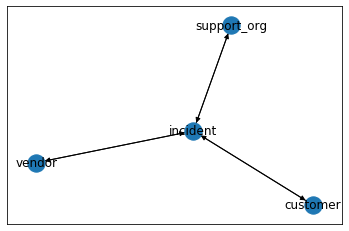

In [6]:
import networkx as nx
import matplotlib.pyplot as plt 
%matplotlib inline
nx.draw_networkx(g.metagraph)

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

class HeteroRGCNLayer1(nn.Module):
    EMBED_SIZE = 64
    VOCAB_SIZE = 2386
    def __init__(self, hidden_size, G):
        super(HeteroRGCNLayer1, self).__init__()
        # Need an embedding layer for each node feature
        self.node_embeddings = {}
        #self.dropouts = {}
        for ntype in G.ntypes:
            # create an embedding for each feature of a node
            self.node_embeddings[ntype] = {}
            num_node_features = G.node_attr_schemes(ntype)['f'].shape[0]
            for feature in range(num_node_features):
                self.node_embeddings[ntype][feature] = nn.Embedding(self.VOCAB_SIZE, self.EMBED_SIZE)
            #self.dropouts[ntype] = nn.Dropout()
        #for name in etypes:
        module_layers = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            num_features = G.node_attr_schemes(srctype)['f'].shape[0]
            module_layers[etype] = nn.Linear(num_features * self.EMBED_SIZE, hidden_size)
        self.weight = nn.ModuleDict(module_layers)
        self.hidden_size = hidden_size

    def forward(self, G):

        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # for each node compute the embedding and store it in the graph
            # iterate over the features of each node and compute the embedding
            the_node_embedding = self.node_embeddings[srctype]
            node_feature_embeddings = []
            num_features = G.node_attr_schemes(srctype)['f'].shape[0]
            for feature in range(num_features):
                feature_embedding_layer = the_node_embedding[feature]
                node_feature_embeddings.append(feature_embedding_layer(G.nodes[srctype].data['f'][:, feature]))
            comp_node_embedding = torch.cat(node_feature_embeddings, 1)
            G.nodes[srctype].data['E'] = comp_node_embedding
            # Compute W_r * h
            Wh = self.weight[etype](G.nodes[srctype].data['E'])  
            #Wh = torch.sum(Wh, dim = 1)
                # Save it in graph for message passing
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            # Specify per-relation message passing functions: (message_func, reduce_func).
            # Note that the results are saved to the same destination feature 'h', which
            # hints the type wise reducer for aggregation.
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
        # Trigger message passing of multiple types.
        # The first argument is the message passing functions for each relation.
        # The second one is the type wise reducer, could be "sum", "max",
        # "min", "mean", "stack"
        G.multi_update_all(funcs, 'sum')
        #return G
        return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}

class HeteroRGCNLayer2(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer2, self).__init__()
        # W_r for each relation
        
        self.weight = nn.ModuleDict({
                name : nn.Linear(in_size, out_size) for name in etypes
            })

    def forward(self, G, feat_dict):
        # The input is a dictionary of node features for each type
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # Compute W_r * h
            Wh = self.weight[etype](feat_dict[srctype])
            # Save it in graph for message passing
            G.nodes[srctype].data['Wh2_%s' % etype] = Wh
            # Specify per-relation message passing functions: (message_func, reduce_func).
            # Note that the results are saved to the same destination feature 'h', which
            # hints the type wise reducer for aggregation.
            funcs[etype] = (fn.copy_u('Wh2_%s' % etype, 'm'), fn.mean('m', 'h2'))
        # Trigger message passing of multiple types.
        # The first argument is the message passing functions for each relation.
        # The second one is the type wise reducer, could be "sum", "max",
        # "min", "mean", "stack"
        G.multi_update_all(funcs, 'sum')
        #return G
        # return the updated node feature dictionary
        return {ntype : G.nodes[ntype].data['h2'] for ntype in G.ntypes}


In [8]:
class HeteroRGCN(nn.Module):
    def __init__(self, G, hidden_size, out_size):
        super(HeteroRGCN, self).__init__()
        # create layers
        self.layer1 = HeteroRGCNLayer1(hidden_size, G)
        self.layer2 = HeteroRGCNLayer2(hidden_size, out_size, G.etypes)

        

    def forward(self, G):
        
        h_dict = self.layer1(G)
        h_dict = {k : F.leaky_relu(h) for k, h in h_dict.items()}
        h_dict = self.layer2(G, h_dict)
        
        # get paper logits
        
        return h_dict['incident']


In [9]:
training_mask = np.random.rand(len(labels)) <= 0.8
train_idx = [i for i in range(len(labels)) if training_mask[i]]
test_idx = [i for i in range(len(labels)) if not training_mask[i]]
train_idx = torch.tensor(train_idx).long()
test_idx = torch.tensor(test_idx).long()
labels = torch.tensor(labels).long()

In [10]:
%%time
# Create the model. The output has three logits for three classes.


#model = HeteroRGCN(G, 512,64, 2)

#opt = torch.optim.SGD(model.parameters(), lr=0.001)
#,
model = HeteroRGCN(g,32,2)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(100):
    opt.zero_grad()
    logits = model(g)
    # The loss is computed only for labeled nodes.
    loss = loss_fn(logits[train_idx], labels[train_idx])
    loss.backward()
    opt.step()
    pred_trng = torch.argmax(logits[train_idx], dim = 1)
    res_trng = pred_trng == labels[train_idx]
    trng_acc = torch.sum(res_trng).item()/labels[train_idx].shape[0]
    
    pred_test = torch.argmax(logits[test_idx], dim = 1)
    res_test = pred_test == labels[test_idx]
    test_acc = torch.sum(res_test).item()/labels[test_idx].shape[0]
    
    
   
    if epoch % 10 == 0:
        print( 'Loss %.4f, training accuracy %.4f, test accuracy %.4f' % ( loss.item(), trng_acc, test_acc ) )

Loss 0.7063, training accuracy 0.4942, test accuracy 0.4940
Loss 0.5283, training accuracy 0.7164, test accuracy 0.7139
Loss 0.4540, training accuracy 0.7803, test accuracy 0.7809
Loss 0.4129, training accuracy 0.8060, test accuracy 0.8087
Loss 0.3886, training accuracy 0.8194, test accuracy 0.8178
Loss 0.3741, training accuracy 0.8271, test accuracy 0.8276
Loss 0.3620, training accuracy 0.8341, test accuracy 0.8337
Loss 0.3514, training accuracy 0.8402, test accuracy 0.8379
Loss 0.3410, training accuracy 0.8471, test accuracy 0.8373
Loss 0.3304, training accuracy 0.8532, test accuracy 0.8391
CPU times: user 23min 24s, sys: 10min 22s, total: 33min 47s
Wall time: 8min
